# Experience to Knowledge (feat. kakao arena 1)

WHY? 전체 프로세스를 정리하해보며, 경험으로 축적하기

프로젝트 진행과정을 간추려 정리하면,
> 1. 데이터 획득.
> 2. 데이터 EDA를 통한 특성, 특이사항 파악 
> 3. 전처리하여 학습데이터 구축
> 4. 모델 학습
> 5. 모델 적용 결과
> 6. 결과분석 -> (2,3,4)로 돌아감


우선 코드의 실행을 위해 다운로드받은 데이터파일 경로를 셋업해주고 EDA를 위해 작성한 유틸들을 임포트 해주자!

In [19]:
DATAFILE_PATH = '../../dataset'
! set DATAFILE_PATH = '../../dataset'

# EDA 과정에서 작성한 코드 
import EDA
eda = EDA.EDA(DATAFILE_PATH)

## 데이터 획득
카카오 아레나에서 제공되는 데이터를 다운로드하기만 하면 됬다. **데이터는 용량이 커서 다운로드에 하루정도의 시간이 걸렸다.** 카테고리 정보를 담은 `cate1.json` 파일과 분류레이블이 달려있는 `8개의 train용` 데이터파일, 분류레이블이 주어지지 않는 `1개의 dev용`과 `2개의 test용`데이터 파일이 주어졌다. 

> 데이터의 용량의 크기는 생각보다 많은 어려움들을 가져왔다. 일단 모든 과정마다 처리 시간이 길어지기 때문에 시간적으로 효율적이도록 구현을 했고, 처리할때마다 컴퓨터의 용량이 부족해서 뭔가를 계속 지우고 있어야됬다... 저장공간부족으로 에러도 여러번 났다. 파일은 여러 청크로 나눠서 처리과정을 거치도록 했다. 다음에는 하드를 하나 사야겠다...

|  ㅇ-ㅇ  | ㅇ-ㅇ  |
| --- | --- |
| 용량 | 약 **96Gbyte** |
| 데이터 갯수 | train-**810만개**, dev-50만개, test-150만개 |
| 주어진 파일 형태 | **hdf5**, json |

다운받은 데이터 목록

In [ ]:
! ls $DATAFILE_PATH

## EDA - 주어진 데이터 특성, 특이사항 파악
주어진 데이터를 살펴보면서, 데이터의 특성을 파악하고 이를 바탕으로 어떤 모델을 구축하는게 좋을지 생각해보았다. 특히 이번 프로젝트에서는 다음 항목을 고려하며 EDA를 진행했다.
> - 실제 데이터의 각 항목에 어떤 값들이 들어있나
> - 이상치는 없는가
> - 주어진 데이터의 분포에 문제는 없는가
> - base code처럼 join한 하나의 라벨(`'b>m>s>d'`)로 처리하는게 좋을까 아님 각각 나눠진 라벨(`b, m, s, d`) 로써 분류모델을 만드는게 좋을까
> - text split을 어떻게 하는게 적절한가

### 카테고리별 라벨정보 확인(cate1.json)
우선 **카테고리 정보(`cate1.json`)를 확인해 인덱싱 번호가 어떤식으로 붙어있는지 확인**해보았다. `json`패키지를 사용해 읽어오고 python3의경우 'utf-8'로 디코드해주는 것을 잊지말자. 이번 데이터의 카테고리별 라벨은 다음과 같이 정리해볼 수 있었다.

| - | - |
| --- | --- |
| b | 1~57 |
| m | 1~552 |
| s | -1, 2~3190|
| d | -1, 2~404 |
***특이사항 : s,d의 경우 1이 없고 대신 정의되지 않는 경우를 나타내는 -1이 있음**

In [4]:
kind = ['b','m','s','d']
for x in kind : 
    print(x, ':', len(eda.cate1[x]))
    
print('contents : \n', str(eda.cate1)[:100], '...')

b : 57
m : 552
s : 3190
d : 404
contents : 
 {'s': {'': -1, '탱크 RC': 1966, '북엔드': 634, '로비의자': 477, '한복/생활한복': 230, '스프링클러': 2517, '피클통조림': 1643, ...


### 데이터 내용 확인
그 다음 데이터의 실제 내용을 확인해보았다. 1. 실제 내용을 살표보고 2. 통계적으로 특징을 살펴보았다.
#### 주어진 데이터 내용 파악
주어진 데이터를 먼저 랜덤하게 확인하도록 하고(감잡기), 특정 값을 갖는 데이터(좀 더 자세히 확인)만 볼 수 있도록 두가지 방법의 코드를 구현해 사용하였다. 
> 어떤식으로 값이 들어가 있는지, 눈에 보이는 특징이나 이상치가 보이진 않는지, 그리고 동일한 상품이라도 항상 같은 결과의 라벨이 붙어있지 않다는 것, 동일한 하위 카테고리가 여러 종류에 상위카테고리를 갖는 경우 등을 확인하게되었다. 

- 랜덤 확인

In [7]:
import numpy as np

h = eda.load_datafile(DATAFILE_PATH + '/train.chunk.09')
random = np.random.randint(h['train']['pid'].shape[0])
eda.show_one(h, random)

pid Y4400073335
product Mickey - Sand Perf Nubuck Leather/Smooth Nubuck Leather 8252111 a027 (관세 및 부과세 포함됨) 
 if split :  ['Mickey', 'Sand', 'Perf', 'Nubuck', 'Leather', 'Smooth', 'Nubuck', 'Leather', 'a', '관세', '및', '부과세', '포함됨']
brand  
 if split :  []
model  
 if split :  []
maker  
 if split :  []
price -1
updttm 20180420080856
img_feat [0.20309323 0.07542448 0.34578097 ... 0.09111865 0.20108558 0.0829398 ]
--------------------------------------------------
bcateid ('신발/수제화', 17)
mcateid ('슬립온', 37)
scateid ('', -1)
dcateid ('', -1)


- 특정 값을 갖는 데이터들을 확인

In [20]:
eda.show_byvalue('브랜드)상신정밀', bywhich='brand', maxshow=3)

pid T4469519774
product 상신정밀_테이퍼핀리머GEM300_25.0mm_390mm 
 if split :  ['상신정밀', '테이퍼핀리머GEM', 'mm', 'mm']
brand 브랜드)상신정밀 
 if split :  ['브랜드', '상신정밀']
model 품명:상신정밀_테이퍼핀리머GEM300_25.0mm_390mm / 모델명:상세정보별도표시 
 if split :  ['품명', '상신정밀', '테이퍼핀리머GEM', 'mm', 'mm', '모델명', '상세정보별도표시']
maker 제조자:상신정밀 / 수입자:상신정밀 
 if split :  ['제조자', '상신정밀', '수입자', '상신정밀']
price 176360
updttm 20180310144702
img_feat [0.         0.01017884 0.         ... 0.01120353 0.33971998 0.40417528]
--------------------------------------------------
bcateid ('산업/공구/안전용품', 28)
mcateid ('전동공구', 47)
scateid ('액세사리/부품', 809)
dcateid ('', -1)
../../dataset/train.chunk.01


pid G4476662317
product 상신정밀_카운터싱크(홀형90도)GEM890_35.0mm_80mm 
 if split :  ['상신정밀', '카운터싱크', '홀형', '도', 'GEM', 'mm', 'mm']
brand 브랜드)상신정밀 
 if split :  ['브랜드', '상신정밀']
model 품명:상신정밀_카운터싱크(홀형90도)GEM890_35.0mm_80mm / 모델명:상세정보별도표시 
 if split :  ['품명', '상신정밀', '카운터싱크', '홀형', '도', 'GEM', 'mm', 'mm', '모델명', '상세정보별도표시']
maker 제조자:상신정밀 / 수입자:상신정밀 
 if split :  ['제조자', '상신

#### 주어진 데이터의 통계적 파악
우선 각 파일의 들어있는 라벨의 종류 살펴보았다. 
> 각 파일에 모든 라벨의 데이터가 들어있지 않았다. 즉 하나의 데이터 파일만 학습시 아예 학습하지 못하는 카테고리 라벨이 존재한다. 특히 **01번 데이터 파일의 경우 `52, 463, 2070, 183`로 가장 한정된 종류의 데이터로 구성**되어있었다.

In [2]:
counts = eda.check_y_proportion('train_data_list', 'train')

[INFO    ] 2019-01-10 18:33:45 [EDA.py] [check_y_proportion:128] Checking label proportion in train_data_list, with 4 core.


processed  ../dataset/train.chunk.01 ( 1000000 ) unique number of b,m,s,d [52, 463, 2070, 183]
processed  ../dataset/train.chunk.04 ( 1000000 ) unique number of b,m,s,d [56, 549, 3103, 394]
processed  ../dataset/train.chunk.03 ( 1000000 ) unique number of b,m,s,d [56, 548, 3102, 396]
processed  ../dataset/train.chunk.02 ( 1000000 ) unique number of b,m,s,d [57, 551, 3097, 380]
processed  ../dataset/train.chunk.05 ( 1000000 ) unique number of b,m,s,d [56, 548, 3100, 397]
processed  ../dataset/train.chunk.06 ( 1000000 ) unique number of b,m,s,d [56, 549, 3105, 397]
processed  ../dataset/train.chunk.07 ( 1000000 ) unique number of b,m,s,d [56, 549, 3105, 396]
processed  ../dataset/train.chunk.08 ( 1000000 ) unique number of b,m,s,d [56, 549, 3107, 397]
processed  ../dataset/train.chunk.09 ( 134818 ) unique number of b,m,s,d [56, 542, 2831, 333]


[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/01
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/02
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/03
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/04
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/05
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/06
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/07
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/08
[INFO    ] 2019-01-10 18:34:18 [EDA.py] [check_y_proportion:143] Save label counting as picke file ./EDA/09


다음으로 각 카테고리의 라벨별 갯수를 살펴보면,
> - 각 카테고리별 갯수가 최대 10만오더, 최소 10오더로 **최대 최소간 만배의 분포 차이**를 보임
> - bmsd 4개의 카테고리를 하나의 string으로 묶어서 새로운 카테고리를 정의한 경우, 가장 다양한 s카테고리보다 1000개 정도 더 증가한 4000여개의 레이블로 분류되며 제일 적은 레이블 데이터수는 9개.
> - d카테고리의 경우 -1인 경우가 약 740만개로 **약 5%정도인 60만개 정도만이 분류값이 존재**한다. 
> - 

In [16]:
import pickle
for x in range(9) :
    if x == 0 :
        total= pickle.loads(open('./EDA/0{}'.format(x+1) , 'rb').read())
    else :
        one = pickle.loads(open('./EDA/0{}'.format(x+1) , 'rb').read())
        for case in ['b','m','s', 'd', 'dummy'] :
            for cat, number in one.get(case).items() :
                total[case][cat] = total[case].get(cat)+ number if total[case].get(cat) else number

57 552 3190 404 4215
category b - most ('가방/지갑/잡화', 14)=>572,932 | least ('여행', 31)=>54
category m - most ('휴대폰액세서리', 3)=>346,249 | least ('기타육류', 545)=>15
category s - most ('', -1)=>1,866,120 | least ('화장품냉장고', 3184)=>10
category d - most ('', -1)=>7,376,926 | least ('용인시', 404)=>11
category dummy - most ('24>31>34>5', 72344) | least ('45>185>290>-1', 9)
카테고리 종류별 라벨 카운트 갯수


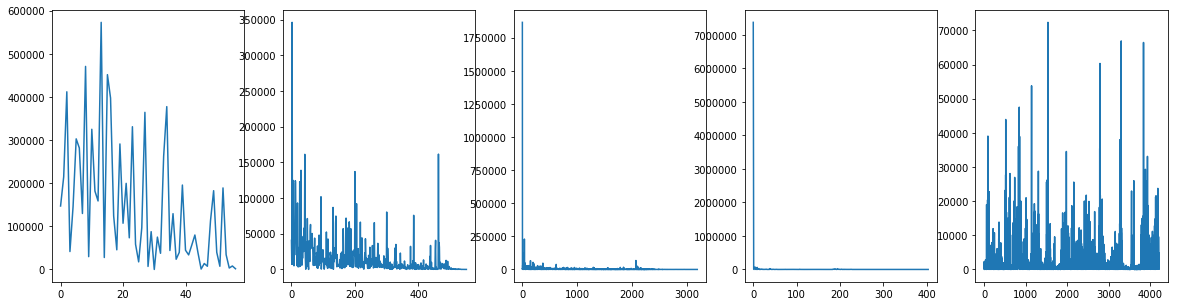

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5.0) # set default size of plots : (width, height)

b, m, s, d, dummy = total['b'], total['m'], total['s'], total['d'], total['dummy']
print(len(b), len(m), len(s), len(d), len(dummy))

def summary(total, cnt, which='b') :
    count = sorted(total[which].items(), key=lambda x : x[0])
    x = [key for key,_ in count]
    y = [val for _,val in count]
    
    plt.subplot(1,5,cnt)
#     plt.bar(x,y)
    plt.plot(y,)

    max_count = max(total[which].items(), key=lambda x : x[1])
    min_count = min(total[which].items(), key=lambda x : x[1])

    if which=='dummy' :
        print('category {} - most {} | least {}'.format(which, max_count, min_count))
    else :
        print('category {} - most {}=>{:,} | least {}=>{:,}'.format(which, eda.catename(which, max_count[0]),int(max_count[1]), eda.catename(which, min_count[0]),int(min_count[1])))
    
summary(total, 1,'b')
summary(total, 2,'m')
summary(total, 3,'s')
summary(total, 4,'d')
summary(total, 5,'dummy')

print('카테고리 종류별 라벨 카운트 갯수')
# print(eda.catename('b',45), edacatename('m', 185), catename('s',290))

In [ ]:
카테고리 컬럼사이의 상관관계

## 전처리하여 학습데이터 구축

특히 신경쓴 부분은, 파일이 크기 때문에 시간효율성을 고려한 코드를 짜는 부분이이었다. 카카오에서 주어진 basecode의 방법은 파일에서 하나씩 데이터를 읽어오는 부분들이 있었는데, 읽어오는 부분에 병목이 생겨 시간비효율성이 존재하고 있었다. 따라서 hdf5파일에서 뭉치로 읽어와서 처리를 하여 4~5시간 걸리는 작업을 30분정도에 수행하도록 코드를 구성했다.

## 모델 정의, 학습

Tensorflow를 사용. 

사용한 파일 형태 hdf5

hdf5 vs tfrecord

h5py, tqdm, json, logging, Pool, Option, matplotlib